## Covid prediction

Welcome to my jupyter notebook, where I document the ever-evolving landscape of the COVID-19 pandemic. As I sit here in New York, almost a month into the quarantine, I can't help but reflect on the tremendous changes that have taken place since I first started this blog in early February. Initially, my goal was to create a reliable source that would collect and present the total number of COVID-19 cases worldwide, as the most updated information was not easily accessible to the public. However, as the situation has progressed, there are now more robust resources available that diligently track and disseminate the research, presenting it in clear and informative graphs.

While the need for my initial data collection efforts has diminished, I still wanted to provide value to my readers. As a result, I am sharing the code that I developed to gather and process the COVID-19 data. The output of this code is presented in CSV format, allowing you to explore and analyze the data yourself. Even though there are other resources available, I believe in the power of transparency and accessibility, and I hope that by sharing my code, I can contribute to the larger effort of understanding and combating this global health crisis.

Please feel free to explore the code below and utilize it to stay informed about the progression of COVID-19. Remember, accurate information is key in these uncertain times, and we must rely on reliable sources to guide our decisions and actions. Together, we can navigate through this challenging period and emerge stronger on the other side.

##### Scrape covid data

In [10]:
from bs4 import BeautifulSoup
from ast import literal_eval
import requests
import re, json
import pandas as pd

def get_text_bs(soup):
    v = {}
    process_array = lambda x : literal_eval(x.split(':')[1].replace(' ',''))

    for chart in soup.select("script"):
        if 'Highcharts.chart' in str(chart):
            chart = str(chart).replace('\n','').split('       ')
            for sector in chart:
                if 'categories' in sector and 'date' not in v.keys():
                    v['date'] = process_array(sector)
                if 'text' in sector:
                    title = sector
                if 'data' in sector:
                    if 'Total Coronavirus Cases' in title:
                        v['total'] = process_array(sector)
                    elif 'Total Coronavirus Deaths' in title:
                        v['death'] = process_array(sector)
                    elif 'Currently Infected' in title:
                        v['active'] = process_array(sector)
                    else:
                        continue
    df = pd.DataFrame(v)
    df['date'] = pd.to_datetime(df['date'],format='%b%d,%Y')
    df.set_index('date', drop=True,inplace=True)
    return df


def data_by_country(countries):
    rs = []
    if isinstance(countries,str):
        countries = [countries]

    for country in countries:
        url = "https://www.worldometers.info/coronavirus/country/" + country
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page,"html.parser")

        rs.append(get_text_bs(soup).add_suffix('_'+country))
    return pd.concat(rs,axis=1)
#     df.to_csv('data/covid_countries.csv')




COUNTRY = ['us','china','italy','spain','south-korea'] #add your countries
covid = data_by_country(countries=COUNTRY)



#### EDA
- plot trend of total confirmed cases and active cases
- plot in log scale too 

In [11]:
from datetime import datetime, timedelta
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [126]:
covid=covid.loc[covid.index<'2023-01-01']


us


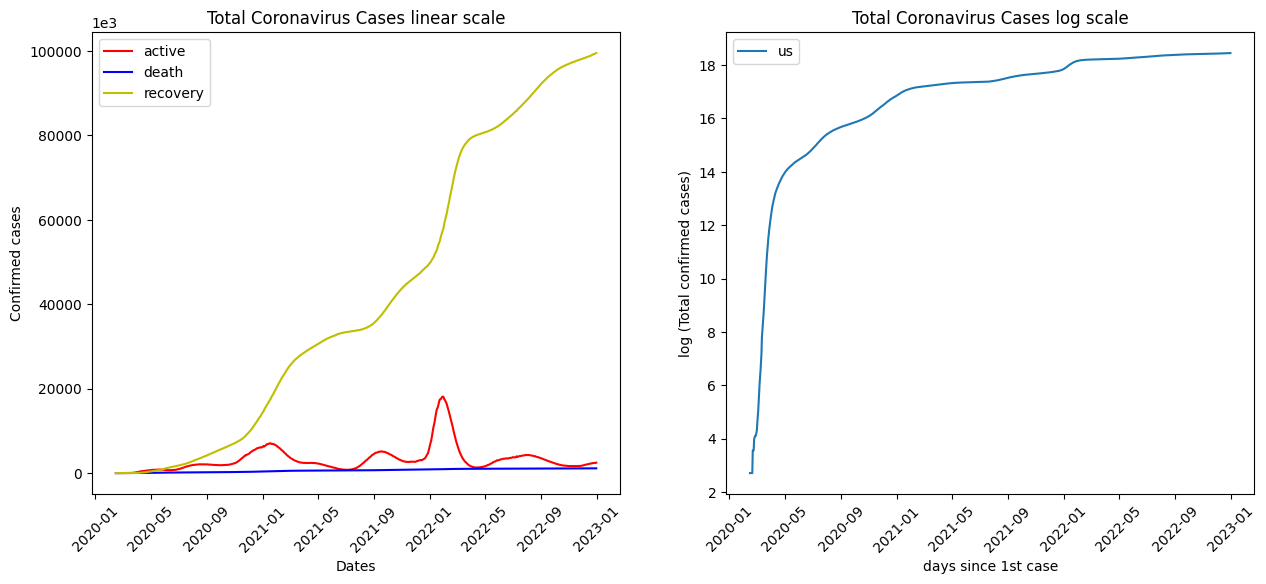

<Figure size 640x480 with 0 Axes>

china


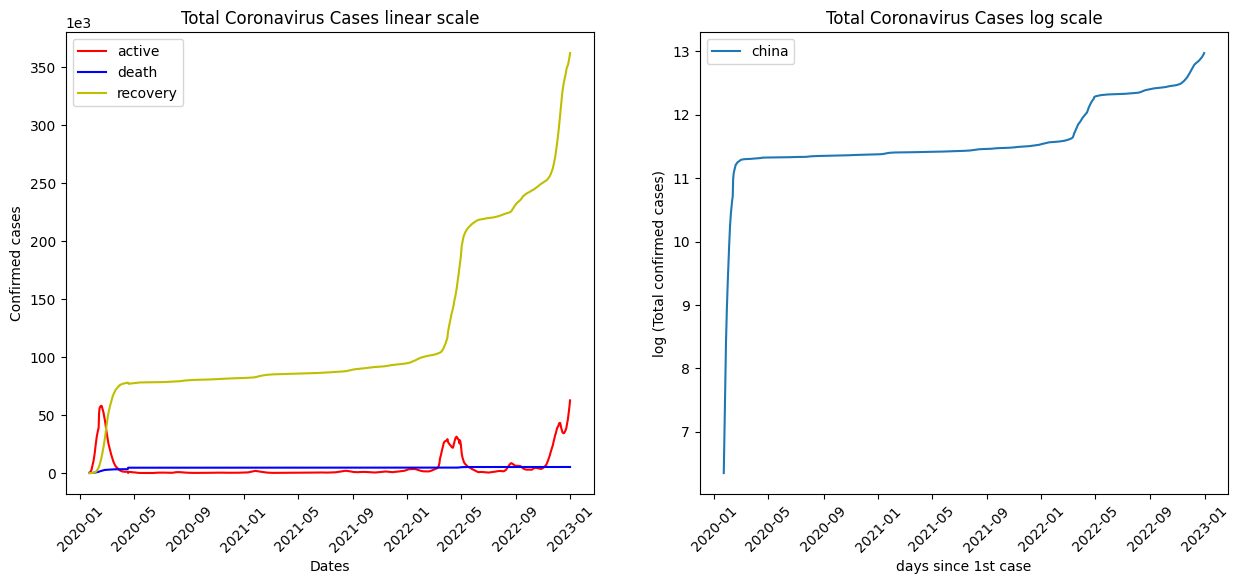

<Figure size 640x480 with 0 Axes>

In [195]:
def linear_regression(y,c):
    '''lack of data in the beginning for china'''
    gap = 14
    lr = LinearRegression(fit_intercept=True)
    m  = 0
    i0 = 0
    if c == 'italy':
        i0 = 14
    for i in range(i0,len(y),gap):
        y_ = y[i:i+gap]
        x_ = np.arange(1,len(y_)+1)
        x_ = x_.reshape(-1,1)
        y_ = y_.reshape(-1,1)
        lr.fit(x_, y_)
        m = max(m,lr.coef_[0][0])
    return m

def plot_total_cases(countries):
    """LOG SCALE"""
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))

    for c in countries:
        print (c)
        i  = covid.index
        y1 = covid['total_'+c]
        y2 = covid['active_'+c]
        y3 = covid['death_'+c]
        
        daily_new = y1.diff()   
        death_rate = y3/y1

        recovery = y1-y3-y2
        plt.figure()
        
#         ax1.plot(i,y1,label='total') 
        ax1.plot(i, y2, 'r-',label="active")
        ax1.plot(i, y3, 'b-',label="death")
        ax1.plot(i, recovery, 'y-',label="recovery")
        
        ax1.tick_params(axis='x', rotation=45)
        ax1.set_ylabel('total')

      

        ax1.set_xlabel('Dates')
        ax1.set_ylabel('Confirmed cases')
        ax1.ticklabel_format(axis="y", style="sci", scilimits=(3,3))
        ax1.set_title('Total Coronavirus Cases linear scale')
        ax1.legend()


        ax2.plot(i,np.log(y1),label=c)


        ax2.legend()
        ax2.set_xlabel('days since 1st case')
        ax2.set_ylabel('log (Total confirmed cases)')
        ax2.set_title('Total Coronavirus Cases log scale' )
        ax2.tick_params(axis='x', rotation=45)

        plt.show()
        
    return
    
    
plot_total_cases(countries=['us'])
plot_total_cases(countries=['china'])

### SI model

The SI (Susceptible-Infectious) model is a simple epidemiological model used to study the spread of disease. In this model, the population is divided into two groups: the susceptible population (S), who are at risk of infection, and the infectious population (I), who are capable of spreading the disease. The total population size is denoted by N, which remains constant throughout the modeling.  

To simplify, let's define population as 1 and I(t) is the percentage of population that is infected

\begin{equation} \label{1}
S(t)+I(t) = 1
\end{equation}


Very often, the rate of infection of a disease is affected by both infection and susceptible population. To consider two extreme cases, 
- when s = 1 , i = 0, the transmission rate, $\beta$ = 0
- when s = 0 , i = 1, everyone is infected and no more new cases, $\beta$ = 0 


\begin{equation} \label{2}
\frac{dI}{dt} = - \frac{dS}{dt} = \beta S I
\end{equation}



This is equation is an ODE function, and we can solve it using Python




date
2020-02-15    1.454787e-07
2020-02-16    1.454787e-07
2020-02-17    1.454787e-07
2020-02-18    1.454787e-07
2020-02-19    1.454787e-07
                  ...     
2022-12-27    9.971877e-01
2022-12-28    9.978609e-01
2022-12-29    9.985951e-01
2022-12-30    9.993445e-01
2022-12-31    1.000000e+00
Freq: D, Name: total_us, Length: 1051, dtype: float64


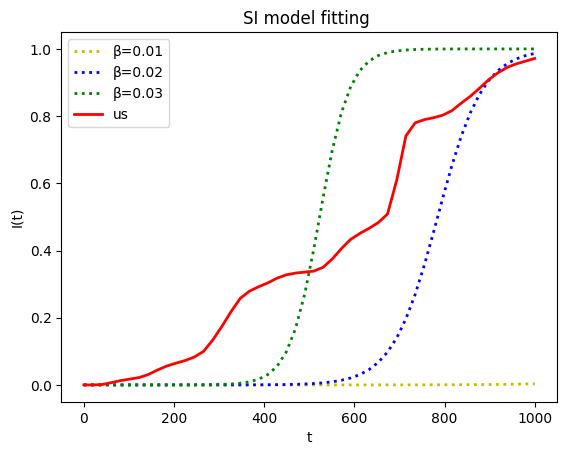

In [203]:
from datetime import datetime, timedelta
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

def model(y,t,k):
    dy_dt = k*y*(1-y)
    return dy_dt

def SI_model(c):
    v = covid['total_'+c]

    v = v[v.notnull()]
    v = (v)/(np.max(v)-np.min(v))  #assume max(v) is population,
    y0 = v[0]
    print (v)
    
    t = np.linspace(0,1000)
    
    # solve ODEs
    k1,k2,k3 = 0.01,0.02,0.03
    y1 = odeint(model,y0,t,args=(k1,))
    y2 = odeint(model,y0,t,args=(k2,))
    y3 = odeint(model,y0,t,args=(k3,))

    # plot results
    plt.plot(t,y1,'y:',linewidth=2,label='β=%.2f'%(k1))
    plt.plot(t,y2,'b:',linewidth=2,label='β=%.2f'%(k2))
    plt.plot(t,y3,'g:',linewidth=2,label='β=%.2f'%(k3))
    d = min(len(t),len(v))
    plt.plot(t,[v.iloc[int(time)]for time in t.round(0)],'r',linewidth=2,label=c)
    
    plt.xlabel('t')
    plt.ylabel('I(t)')
    plt.legend()
    plt.title('SI model fitting ')

    plt.show()
    
SI_model(c='us')


/var/folders/nb/dkj5xcb5285dnpgjlrmzx1xm0000gn/T/ipykernel_43922/1983319659.py:10: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * t)


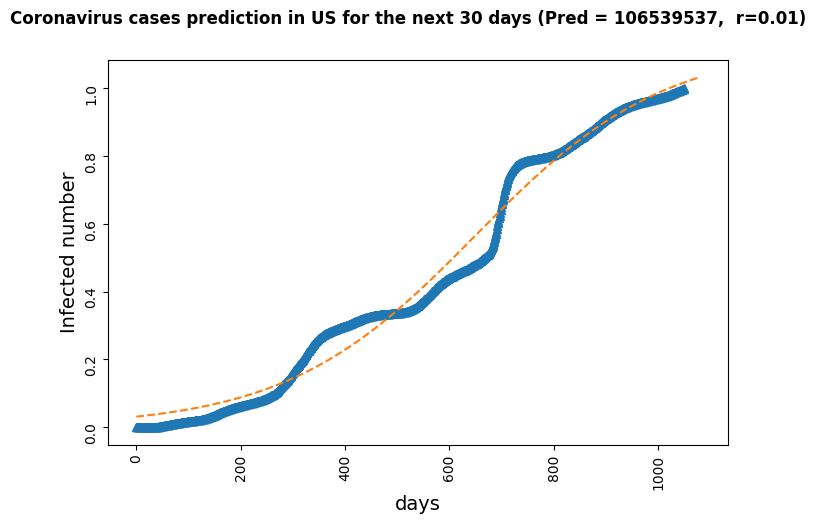

In [204]:
from scipy.optimize import curve_fit
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
 
def logistic_function(t, K, P0, r):
    exp = np.exp(-r * t)
    return 1 / (K + (exp+1) * P0)
 
def prediction(c):

    predict_days = 30
    confirm = covid['total_'+c]
    confirm = confirm[confirm.notnull()]
    scaler = np.max(confirm)
    confirm = confirm/(scaler)


    x = np.arange(len(confirm))
    # curve fit
    popt, pcov = curve_fit(logistic_function, x, confirm,maxfev=2000)
    #predit future
    predict_x = list(x) + [x[-1] + i for i in range(1, 1 + predict_days)]
    predict_x = np.array(predict_x)
    predict_y = logistic_function(predict_x, popt[0], popt[1], popt[2])
    plt.figure(figsize=(8, 5))
    plt.plot(x, confirm, '^',label="confimed infected number")
    plt.plot(predict_x, predict_y, '--',label="predicted infected number")
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)

    plt.suptitle("Coronavirus cases prediction in %s for the next %d days (Pred = %d,  r=%.2f)"%(c.upper(),predict_days,scaler*predict_y[-1], popt[2]), fontsize=12, fontweight="bold")
    plt.xlabel('days', fontsize=14)
    plt.ylabel('Infected number', fontsize=14)
    plt.show()
    
prediction(c='us')

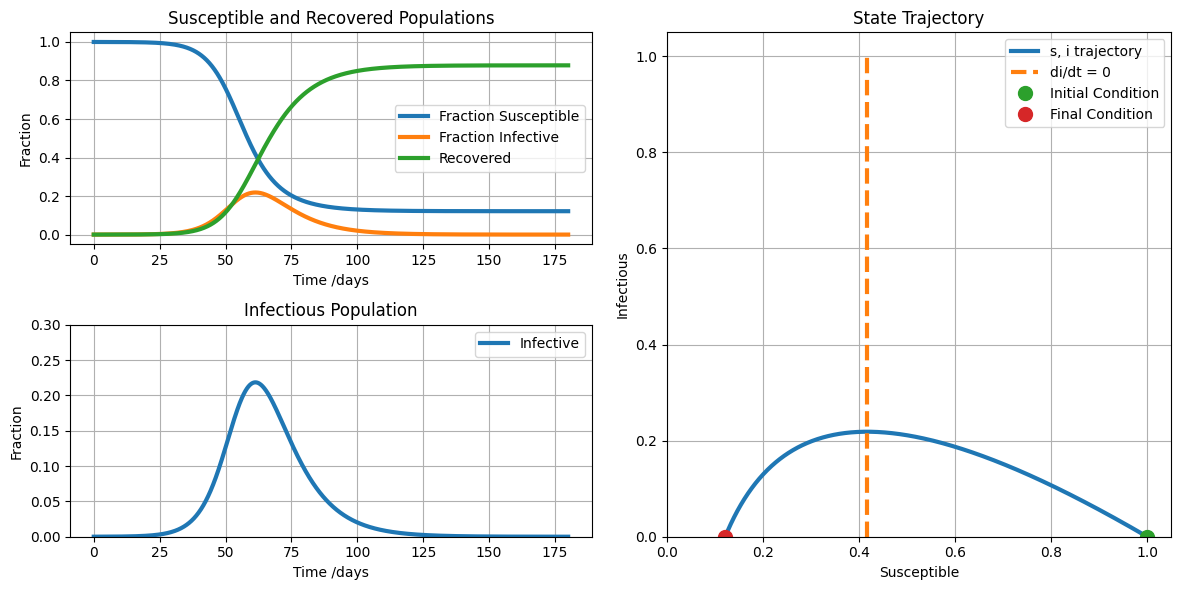

In [66]:
SIR MODEL 
# import numpy as np
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt

# # parameter values
# R0 = 2.4
# t_infective = 5.1 + 3.3

# # initial number of infected and recovered individuals
# i_initial = 1/20000
# r_initial = 0.00
# s_initial = 1 - i_initial - r_initial

# gamma = 1/t_infective
# beta = R0*gamma

# # SIR model differential equations.
# def deriv(x, t, beta, gamma):
#     s, i, r = x
#     dsdt = -beta * s * i
#     didt = beta * s * i - gamma * i
#     drdt =  gamma * i
#     return [dsdt, didt, drdt]

# t = np.linspace(0, 180, 2000)
# x_initial = s_initial, i_initial, r_initial
# soln = odeint(deriv, x_initial, t, args=(beta, gamma))
# s, i, r = soln.T
# e = None

# def plotdata(t, s, i, e=None):
#     # plot the data
#     fig = plt.figure(figsize=(12,6))
#     ax = [fig.add_subplot(221, axisbelow=True), 
#           fig.add_subplot(223),
#           fig.add_subplot(122)]

#     ax[0].plot(t, s, lw=3, label='Fraction Susceptible')
#     ax[0].plot(t, i, lw=3, label='Fraction Infective')
#     ax[0].plot(t, r, lw=3, label='Recovered')
#     ax[0].set_title('Susceptible and Recovered Populations')
#     ax[0].set_xlabel('Time /days')
#     ax[0].set_ylabel('Fraction')

#     ax[1].plot(t, i, lw=3, label='Infective')
#     ax[1].set_title('Infectious Population')
#     if e is not None: ax[1].plot(t, e, lw=3, label='Exposed')
#     ax[1].set_ylim(0, 0.3)
#     ax[1].set_xlabel('Time /days')
#     ax[1].set_ylabel('Fraction')

#     ax[2].plot(s, i, lw=3, label='s, i trajectory')
#     ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
#     ax[2].plot(s[0], i[0], '.', ms=20, label='Initial Condition')
#     ax[2].plot(s[-1], i[-1], '.', ms=20, label='Final Condition')
#     ax[2].set_title('State Trajectory')
#     ax[2].set_aspect('equal')
#     ax[2].set_ylim(0, 1.05)
#     ax[2].set_xlim(0, 1.05)
#     ax[2].set_xlabel('Susceptible')
#     ax[2].set_ylabel('Infectious')

#     for a in ax: 
#         a.grid(True)
#         a.legend()

#     plt.tight_layout()
    
# plotdata(t, s, i)

In [ ]:
# https://github.com/YiranJing/Coronavirus-Epidemic-COVID-19/blob/master/Model%202/SIR_model.py